In [16]:
import open3d as o3d
import pyrealsense2 as rs
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import itertools

import pyvista as pv

In [62]:
nframes = 60

# Camera RIGHT
pipeline = rs.pipeline()
config = rs.config()
config.enable_device('233722072412')
config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)

# Camera LEFT
pipeline_2 = rs.pipeline()
config_2 = rs.config()
config_2.enable_device('032622070359')
config_2.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
config_2.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)


align = rs.align(rs.stream.depth)
cfg = pipeline.start(config)
profile = cfg.get_stream(rs.stream.depth)
intr_right = profile.as_video_stream_profile().get_intrinsics()

cfg_2 = pipeline_2.start(config_2)
profile_2 = cfg_2.get_stream(rs.stream.depth)
intr_left = profile_2.as_video_stream_profile().get_intrinsics()

depths_left = []
depths_right = []
cnt = 0
while cnt<=90+nframes:
    # RIGHT
    frames = pipeline.wait_for_frames()
    frames = align.process(frames)
    depth_frame = frames.get_depth_frame()
    depth_image = np.asarray(depth_frame.get_data())
    if cnt>90:
        depths_right.append(depth_image)
    color_frame = frames.get_color_frame()
    color_image = np.asarray(color_frame.get_data())

    #LEFT
    frames_2 = pipeline_2.wait_for_frames()
    frames_2 = align.process(frames_2)
    depth_frame_2 =frames_2.get_depth_frame()
    depth_image_2 = np.asarray(depth_frame_2.get_data())
    if cnt>=90:
        depths_left.append(depth_image_2)
    color_frame_2 = frames_2.get_color_frame()
    color_image_2 = np.asarray(color_frame_2.get_data())

    cnt += 1

     
pipeline.stop()
pipeline_2.stop()

mean_left = np.uint16(np.median(np.asarray(depths_left), 0)) 
mean_right = np.uint16(np.median(np.asarray(depths_right), 0))
cv2.imwrite("leftDepth.png", mean_left)
cv2.imwrite("leftColor.jpg", color_image_2)
cv2.imwrite("rightDepth.png", mean_right)
cv2.imwrite("rightColor.jpg", color_image)
depth_raw_left = o3d.io.read_image("leftDepth.png")
color_raw_left = o3d.io.read_image("leftColor.jpg")
depth_raw_right = o3d.io.read_image("rightDepth.png")
color_raw_right = o3d.io.read_image("rightColor.jpg")
rgbd_image_left = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_left, depth_raw_left)
rgbd_image_right = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_right, depth_raw_right)

In [63]:
variances = np.zeros((720, 1280))
means = np.zeros((720, 1280))
inliers = np.zeros((720, 1280))
for i in range(0, 720):
    for j in range(0, 1280):
        support = []
        for k in range(0, nframes):
            if depths_left[k][i][j] > 0:
                support.append(depths_left[k][i][j])
        if len(support) > 0:
            inliers[i,j] = len(support)
            variances[i,j] = np.var(support)
            means [i,j] = np.mean(support)
        else:
            variances[i,j] = -1

In [64]:
max_value = variances.max()
invalid_indexes = np.argwhere(variances==-1)
valid_variances = variances
valid_variances[invalid_indexes[:,0], invalid_indexes[:,1]] = max_value
threshold = np.median(variances[variances!=-1])
print(f'Threshold: {threshold}')

Threshold: 7.428085714285714


In [65]:
valid_variances[valid_variances ==0].shape

(97980,)

In [66]:
from scipy.interpolate import interp1d

img_indexes = np.argwhere(valid_variances<threshold)
high_variance_indexes = np.argwhere(valid_variances>=threshold)

zero_variance_indexes = np.argwhere(valid_variances==0)
zero_variance_image = np.zeros((720, 1280))
zero_variance_image[zero_variance_indexes[:,0], zero_variance_indexes[:,1]] = 255


variance_image = np.zeros((720, 1280))
m = interp1d([valid_variances.min(),threshold],[0,255])
variance_image[img_indexes[:,0], img_indexes[:,1]] =  m(valid_variances[img_indexes[:,0], img_indexes[:,1]])


variance_image[high_variance_indexes[:,0], high_variance_indexes[:,1]] = 255

In [67]:
zero_variance_indexes.shape[0] / (1280*720)

0.10631510416666666

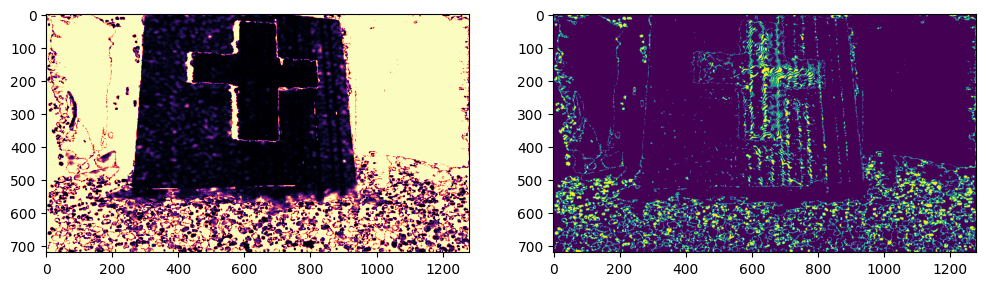

LEFT IMAGE: variance map with max value: 7.428085714285714 mm
RIGHT IMAGE: Zero variance map


In [68]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(variance_image, cmap="magma")
cv2.imwrite("varianza zero.png", variance_image)
plt.subplot(1,2,2)
plt.imshow(zero_variance_image)
plt.show()
print(f'LEFT IMAGE: variance map with max value: {threshold} mm\nRIGHT IMAGE: Zero variance map')

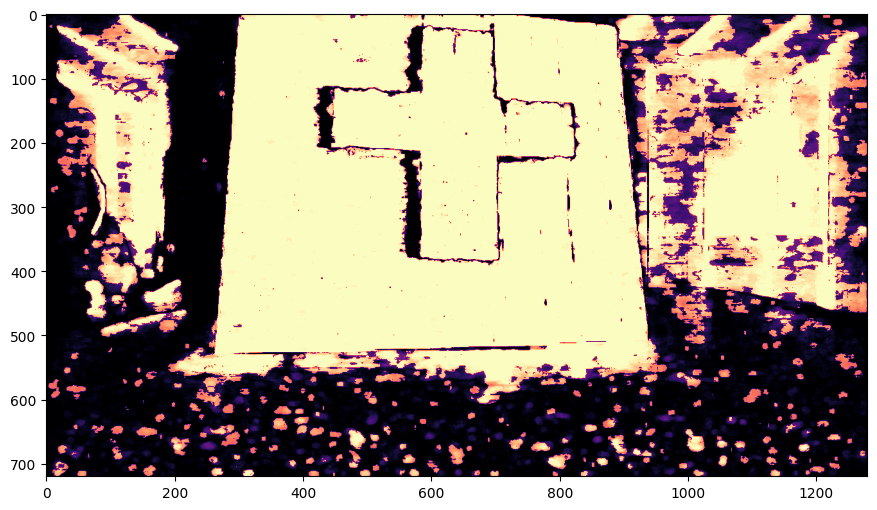

In [69]:
# Inliers map
from scipy.interpolate import interp1d

m = interp1d([inliers.min(),inliers.max()],[0,255])
inliers_map = m(inliers)
plt.figure(figsize=(12,6))
plt.imshow(inliers_map, cmap="magma")

In [71]:
hist_variance, aa = np.histogram(valid_variances[valid_variances < threshold], bins=20)

In [72]:
hist_variance, aa

(array([325533,  60463,  25974,  12014,   7423,   5492,   4769,   3035,
          2189,   2395,   2195,   1436,   1415,   1058,   1298,    718,
          1514,    621,    726,    532], dtype=int64),
 array([0.     , 0.37138, 0.74276, 1.11414, 1.48552, 1.8569 , 2.22828,
        2.59966, 2.97104, 3.34242, 3.7138 , 4.08518, 4.45656, 4.82794,
        5.19932, 5.5707 , 5.94208, 6.31346, 6.68484, 7.05622, 7.4276 ]))

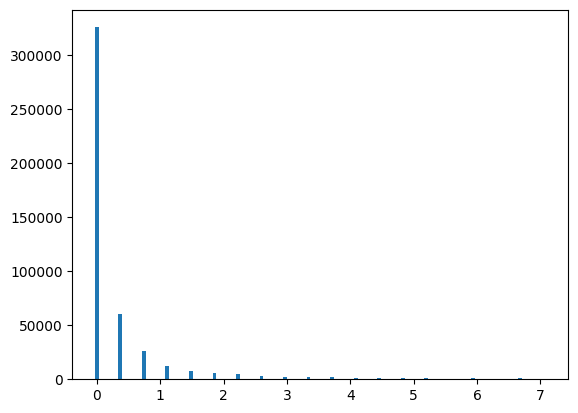

In [73]:
plt.bar(aa[:-1], hist_variance, width=0.06)  # arguments are passed to np.histogram

plt.show()

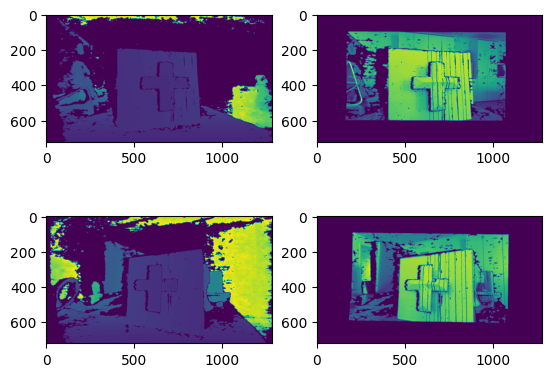

In [318]:
plt.subplot(2,2,1)
plt.imshow(rgbd_image_left.depth)
plt.subplot(2,2,2)
plt.imshow(rgbd_image_left.color)
plt.subplot(2,2,3)
plt.imshow(rgbd_image_right.depth)
plt.subplot(2,2,4)
plt.imshow(rgbd_image_right.color)

In [319]:
import copy

def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    #target_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4459,
                                      front=[1.0, 0.0, 0.0],
                                      lookat=[1, 0, 0],
                                      up=[-0., 1, -0.0])

In [320]:
camera_intrinsic_left = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr_left.width, intr_left.height, intr_left.fx, intr_left.fy, intr_left.ppx, intr_left.ppy
))
camera_intrinsic_right = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr_right.width, intr_right.height, intr_right.fx, intr_right.fy, intr_right.ppx, intr_right.ppy
))

In [325]:
pcd_left = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_left, camera_intrinsic_left)
pcd_right = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_right, camera_intrinsic_right)

bounds = [[-math.inf, math.inf], [-math.inf, 0.15], [0.1, 0.7]]  # set the bounds
bounding_box_points = list(itertools.product(*bounds))  # create limit points
bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object

# Crop the point cloud using the bounding box:
pcd_left = pcd_left.crop(bounding_box)
pcd_right = pcd_right.crop(bounding_box)

# Rotazione di 180° intorno all'asse X (ribaltare la point cloud poiché la pinhole camera ribalta la visuale)
angolo = np.pi
trans_x = np.asarray([   [1.0, 0.0, 0.0, 0.0],
                         [0.0, np.cos(angolo), -np.sin(angolo), 0.0],
                         [0.0, np.sin(angolo), np.cos(angolo), 0.0],
                         [0.0, 0.0, 0.0, 1.0]])

pcd_left.transform(trans_x)
pcd_right.transform(trans_x)

# Primario -> Camera di destra 
# Secondario -> Camera di sinistra

# Rotazione di -30° intorno all'asse Y
angolo = np.pi/6
trans_y = np.asarray([[np.cos(angolo), 0.0, np.sin(angolo), -0.34],
                         [0.0, 1.0, 0.0, 0.0],
                         [-np.sin(angolo), 0.0, np.cos(angolo), 0.0],
                         [0.0, 0.0, 0.0, 1.0]])

#pcd_left.transform(trans_y)

#pcd_left.paint_uniform_color((1,0,0))  # LEFT BLU

#pcd_right.paint_uniform_color((0,0,1)) # RIGHT ROSSO

o3d.visualization.draw_geometries([pcd_left, pcd_right])

In [322]:
angolo = np.pi/6
source = pcd_left
target = pcd_right
threshold = 0.01
trans_init = np.asarray([[np.cos(angolo), 0.0, -np.sin(angolo), -0.31],
                         [0.0, 1.0, 0.0, 0.0],
                         [np.sin(angolo), 0.0, np.cos(angolo), -0.1],
                         [0.0, 0.0, 0.0, 1.0]])
draw_registration_result(source, target, trans_init)

In [323]:
print("Initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(
    source, target, threshold, trans_init)
print(evaluation)

Initial alignment
RegistrationResult with fitness=2.188902e-01, inlier_rmse=4.658309e-03, and correspondence_set size of 36262
Access transformation to get result.


In [326]:
print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=10000))
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
draw_registration_result(source, target, reg_p2p.transformation)


Apply point-to-point ICP
RegistrationResult with fitness=8.910801e-01, inlier_rmse=2.064674e-03, and correspondence_set size of 147619
Access transformation to get result.
Transformation is:
[[ 7.67056743e-01 -1.02641178e-02 -6.41497156e-01 -3.04310857e-01]
 [ 1.97252309e-02  9.99776634e-01  7.58934966e-03 -9.84407852e-04]
 [ 6.41275969e-01 -1.84751414e-02  7.67087870e-01 -1.39646879e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: L'operazione di trasformazione richiesta non è supportata. 


In [328]:
calibrated_matrix = reg_p2p.transformation

In [ ]:
Media, varianza e superstiti per ogni pixel di profondità

In [330]:
pcd_left = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_left, camera_intrinsic_left)
pcd_right = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_right, camera_intrinsic_right)

bounds = [[-math.inf, math.inf], [-math.inf, 0.15], [0.1, 1.0]]  # set the bounds
bounding_box_points = list(itertools.product(*bounds))  # create limit points
bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object

# Crop the point cloud using the bounding box:
pcd_left = pcd_left.crop(bounding_box)
pcd_right = pcd_right.crop(bounding_box)

# Rotazione di 180° intorno all'asse X (ribaltare la point cloud poiché la pinhole camera ribalta la visuale)
angolo = np.pi
trans_x = np.asarray([   [1.0, 0.0, 0.0, 0.0],
                         [0.0, np.cos(angolo), -np.sin(angolo), 0.0],
                         [0.0, np.sin(angolo), np.cos(angolo), 0.0],
                         [0.0, 0.0, 0.0, 1.0]])

pcd_left.transform(trans_x)
pcd_right.transform(trans_x)


pcd_left.transform(calibrated_matrix)

#pcd_left.paint_uniform_color((1,0,0))  # LEFT BLU

#pcd_right.paint_uniform_color((0,0,1)) # RIGHT ROSSO

o3d.visualization.draw_geometries([pcd_left, pcd_right])

In [327]:
test = pcd_left.transform(reg_p2p.transformation)
p1_load = np.asarray(test.points)
p1_color = np.asarray(test.colors)
p2_load = np.asarray(pcd_right.points)
p2_color = np.asarray(pcd_right.colors)

p3_load = np.concatenate((p1_load, p2_load), axis=0)
p3_color = np.concatenate((p1_color, p2_color), axis=0)

new_pcd = o3d.geometry.PointCloud()
new_pcd.points = o3d.utility.Vector3dVector(p3_load)
new_pcd.colors = o3d.utility.Vector3dVector(p3_color)

In [70]:
o3d.visualization.draw_geometries([new_pcd])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Handle non valido. 
